# Description
Notebook to create figures in the paper: "Continuity between ancient geochemistry and modern metabolism enabled by non-autocatalytic purine biosynthesis" by Goldford, J.E., Smith, H.B., Longo, L.M. Wing, B.A. & McGlynn, S.M.

### Load packages

In [41]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
#metabolism = load_data('metabolism.23Aug2022.pkl')
#model_id = "metabolism.v4.20Mar2023.pkl"
#model_id = "metabolism.v5.12Apr2023.pkl"
#model_id = "metabolism.v6.26Apr2023.pkl"
#model_id = "metabolism.v8.01May2023.pkl"
model_id = "metabolism.v8.allPhosphate.06May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [42]:
model_id2 = "metabolism.v8.01May2023.pkl"
#model_id2 = "metabolism.v8.allPhosphate.06May2023.pkl"
mx = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id2)

In [43]:
m1 = metabolism.network[metabolism.network.rn.apply(lambda x: "_g" in x)].rn.unique().tolist()
m2 = mx.network[mx.network.rn.apply(lambda x: "_g" in x)].rn.unique().tolist()

### Run network expansion

In [48]:
seed_set = pd.read_csv('../assets/seed_set.csv')['ID'].tolist()
#seed_df = pd.read_csv('assets/seed_set.csv')
#seed_set = seed_df[~seed_df.Type.isin(["Organic carbon"])].ID.tolist()
#seed_set = seed_set + ["C00010"]

print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])


There were 70 compounds in this seed set...
There were 4315 compounds produced in this expansion!


In [50]:
ne_cpds_orig,_ = mx.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds_orig)))

There were 4315 compounds produced in this expansion!


<AxesSubplot:xlabel='iter (orig)', ylabel='iter (added)'>

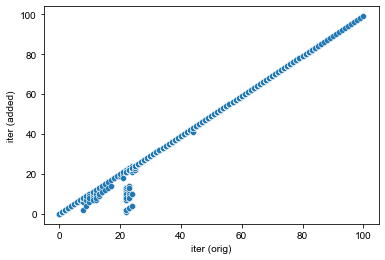

In [55]:
cpds = pd.DataFrame(pd.Series(ne_cpds_orig),columns=["iter (orig)"])
cpds2 = pd.DataFrame(pd.Series(ne_cpds),columns=["iter (added)"])
cpds= cpds.join(cpds2)
sns.scatterplot(x='iter (orig)',y='iter (added)',data=cpds)

In [61]:
pearsonr(cpds['iter (orig)'].values,cpds['iter (added)'].values)

(0.9970342209725389, 0.0)

### Figure 1A. Run network expansion w/o non-autocatalytic purine biosynthesis +/- adenine, and plot traces

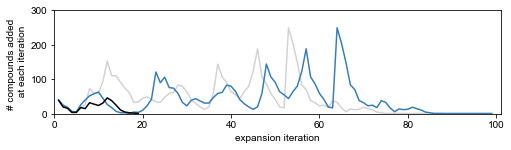

In [11]:
# now remove purine production 
metab_unmod = metabolism.copy()
ne_cpds,ne_rxns = metab_unmod.expand(seed_set,algorithm='trace')
rn_to_remove = [x for x in metab_unmod.network.rn.unique().tolist() if (('_gATP' in x) or ('_gGTP' in x))]
metab_unmod.network = metab_unmod.network[~metab_unmod.network.rn.isin(rn_to_remove)]
ne_cpds_np,ne_rxns_np = metab_unmod.expand(seed_set,algorithm='trace')
ne_cpds_np_ad,ne_rxns_np_ad = metab_unmod.expand(seed_set + ['C00147'],algorithm='trace')


cmap = sns.color_palette("Set1")
abun = pd.DataFrame(pd.Series(ne_cpds),columns=['iter']).reset_index().groupby('iter').count()
abun['compounds (cumulative)'] = abun['index'].cumsum()

abun_alt = pd.DataFrame(pd.Series(ne_cpds_np),columns=['iter']).reset_index().groupby('iter').count()
abun_alt['compounds (cumulative)'] = abun_alt['index'].cumsum()

abun_ad = pd.DataFrame(pd.Series(ne_cpds_np_ad),columns=['iter']).reset_index().groupby('iter').count()
abun_ad['compounds (cumulative)'] = abun_ad['index'].cumsum()

#sns.scatterplot(x='iter',y='compounds (cumulative)',data=abun)
#plt.figure(figsize=(8,4/14*8))

plt.figure(figsize=(8,4/14*8))

sns.lineplot(x='iter',y='index',data=abun_ad.iloc[1:],color='lightgrey')
sns.lineplot(x='iter',y='index',data=abun.iloc[1:],color=cmap[1])
sns.lineplot(x='iter',y='index',data=abun_alt.iloc[1:],color="k")

plt.ylabel('# compounds added \n at each iteration')
plt.xlabel("expansion iteration")
plt.xlim([0,101])
plt.ylim([0,300])
plt.subplots_adjust(bottom=0.25)
#plt.legend(['Unmodified + adenine','Modified','Unmodified'])
#plt.savefig("figs/fig1a_rs.svg")

### Figure S1: Add ATLAS reactions to KEGG network and repeat expansions

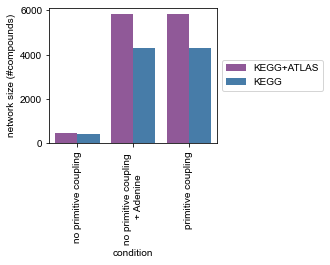

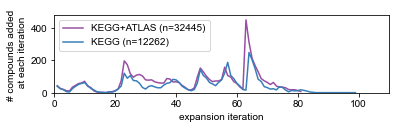

In [13]:
# run atlas analysis
ar = pd.read_csv('../assets/atlas_reactions.csv')
ar= ar[['rn','direction','cid','s','ub','lb']]
ar['stoich_str'] = np.nan
ar['rn_old'] = np.nan

matlas = metabolism.copy()
# make KEGG+ATLAS network with non-autocatalytic purine production
matlas.network = pd.concat([matlas.network,ar],axis=0)
# make KEGG+ATLAS network without non-autocatalytic purine production
matlas_nc = matlas.copy()
matlas_nc.network = matlas_nc.network[~matlas_nc.network.rn.apply(lambda x: ('_gATP' in x) or ('_gGTP' in x))]

# make KEGG network without non-autocatalytic purine production
metabolism_nc = metabolism.copy()
metabolism_nc.network = metabolism_nc.network[~metabolism_nc.network.rn.apply(lambda x: ('_gATP' in x) or ('_gGTP' in x))]

# perform network expansion for KEGG+ATLAS, without non-autocatalytic purine production
c_atl_nc,rx = matlas_nc.expand(seed_set,algorithm='naive')
c_atl_nc = len(c_atl_nc)

# perform network expansion for KEGG+ATLAS, without non-autocatalytic purine production, plus adenine
c_atl_nc_ad,rx = matlas_nc.expand(seed_set + ['C00147'],algorithm='naive')
c_atl_nc_ad = len(c_atl_nc_ad)


# perform network expansion for KEGG+ATLAS, with non-autocatalytic purine production
c_atl,rx = matlas.expand(seed_set,algorithm='naive')
c_atl = len(c_atl)


# perform network expansion for KEGG, without non-autocatalytic purine production
c_kegg_nc,rx = metabolism_nc.expand(seed_set,algorithm='naive')
c_kegg_nc = len(c_kegg_nc)

# perform network expansion for KEGG, without non-autocatalytic purine production, plus adenine
c_kegg_nc_ad,rx = metabolism_nc.expand(seed_set + ['C00147'],algorithm='naive')
c_kegg_nc_ad = len(c_kegg_nc_ad)


# perform network expansion for KEGG, with non-autocatalytic purine production
c_kegg,rx = metabolism.expand(seed_set,algorithm='naive')
c_kegg = len(c_kegg)

# store results in a dataframe
results = {'network':['KEGG+ATLAS','KEGG+ATLAS','KEGG+ATLAS','KEGG','KEGG','KEGG'],
          'condition': ['no primitive coupling','no primitive coupling \n + Adenine','primitive coupling','no primitive coupling','no primitive coupling \n + Adenine','primitive coupling'],
          'network size (#compounds)': [c_atl_nc,c_atl_nc_ad,c_atl,c_kegg_nc,c_kegg_nc_ad,c_kegg]}
results = pd.DataFrame(results)


cmap = sns.color_palette("Set1")
plt.figure(figsize=(3,2.5))
ax = sns.barplot(hue='network',x='condition',y='network size (#compounds)',data=results,palette=[cmap[3],cmap[1]])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)


# plot the traces for ATLAS vs KEGG
ne_cpds_atl,rx = matlas.expand(seed_set,algorithm='trace')
abun_atlas = pd.DataFrame(pd.Series(ne_cpds_atl),columns=['iter']).reset_index().groupby('iter').count()
abun_atlas['compounds (cumulative)'] = abun_atlas['index'].cumsum()

h = 6
plt.figure(figsize=(h,4/14*h))
sns.lineplot(x='iter',y='index',data=abun_atlas.iloc[1:],color=cmap[3])
sns.lineplot(x='iter',y='index',data=abun.iloc[1:],color=cmap[1])

plt.ylabel('# compounds added \n at each iteration')
plt.xlabel("expansion iteration")
plt.xlim([0,110])
plt.ylim([0,480])
plt.subplots_adjust(bottom=0.25)
plt.legend(['KEGG+ATLAS (n=32445)','KEGG (n=12262)'])#


### Figure 2B: Plot results of network expansion with coenzyme addition

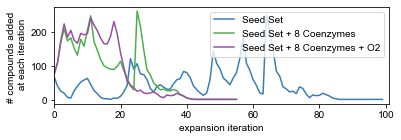

In [14]:
# make figure 2B
cpd_added =['C00002','C00004','C00010','C00016','C00019','Z00035','Z00009','Z00047']
height = 6
plt.figure(figsize=(height,5/14*height))


nc,nr = metabolism.expand(seed_set,algorithm='trace')
abun = pd.DataFrame(pd.Series(nc),columns=['iter']).reset_index().groupby('iter').count()

nc,nr = metabolism.expand(seed_set + cpd_added,algorithm='trace')
abun_sub = pd.DataFrame(pd.Series(nc),columns=['iter']).reset_index().groupby('iter').count()


nc,nr = metabolism.expand(seed_set + cpd_added + ['C00007'],algorithm='trace')
abun_sub2 = pd.DataFrame(pd.Series(nc),columns=['iter']).reset_index().groupby('iter').count()


sns.lineplot(x='iter',y='index',data=abun.iloc[0:],color=cmap[1])
sns.lineplot(x='iter',y='index',data=abun_sub.iloc[0:],color=cmap[2])
sns.lineplot(x='iter',y='index',data=abun_sub2.iloc[0:],color=cmap[3])

plt.ylabel('# compounds added \n at each iteration')
plt.xlabel("expansion iteration")
plt.xlim([0,101])
#plt.ylim([0,255])
plt.subplots_adjust(bottom=0.25)
plt.legend(['Seed Set','Seed Set + 8 Coenzymes','Seed Set + 8 Coenzymes + O2'])
plt.savefig("figs/fig2b.svg")


### Fig 3A: average molecular complexity vs. expansion iteration

Text(0.1, 0.75, '$r=0.71$ \n$P<10^{-16}$')

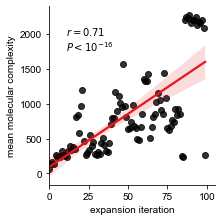

In [16]:
skws={"color": "black"}
lkws={'color': cmap[0]}
complexity = pd.read_csv('../assets/kegg_cpds.iterationComplexity.csv',index_col=0)
complexity = complexity[['complexity']].join(pd.DataFrame(pd.Series(ne_cpds),columns=['iteration']))
sns.lmplot(x='iteration',y='complexity',data=complexity.groupby('iteration').mean().reset_index(),height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlim([0,105])
plt.ylabel('mean molecular complexity')
plt.xlabel('expansion iteration')
c = complexity.groupby('iteration').mean().reset_index()


r,pval = pearsonr(c['iteration'].values,c['complexity'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.75), xycoords='axes fraction')


### Fig 3B: average genome representation vs. expansion iteration

Text(0.1, 0.1, '$r=-0.82$ \n$P<10^{-24}$')

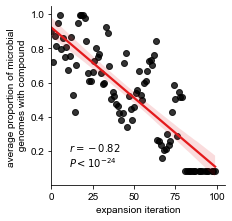

In [17]:
cpd_df = pd.DataFrame(pd.Series(ne_cpds)).reset_index()
cpd_df.columns = ['cid','iteration']
md2cpd = pd.read_csv('../assets/KEGG_ModuleVsCompound.csv')
kegg_modules = pd.read_csv('../assets/KEGG_GenomesToModule.csv')
genome_cids = kegg_modules.set_index('module').join(md2cpd.set_index('module'))[['genome','cid']].drop_duplicates()
genome_cids['count'] = 1
genome_cids_counts = genome_cids.groupby('cid').sum()
N = len(kegg_modules.genome.unique())
ne_genomes_cid = genome_cids_counts.join(cpd_df.set_index('cid'))
ne_genomes_cid['genome_percentage']= ne_genomes_cid['count'] / N
ne_genomes_cid['expansion'] = ~ne_genomes_cid.iteration.isna()
q = ne_genomes_cid.dropna().groupby('iteration').mean().reset_index()


skws={"color": "black"}
lkws={'color': cmap[0]}

sns.lmplot(x='iteration',y='genome_percentage',data=q,height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlabel('expansion iteration')
plt.ylabel('average proportion of microbial \n genomes with compound')

plt.xlim([0,105])


r,pval = pearsonr(q['iteration'].values,q['genome_percentage'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.1), xycoords='axes fraction')


### Fig 3C: proportion of metal usage vs. expansion iteration

-0.7780678923074873
1.6736702863291612e-21


Text(0.6, 0.75, '$r=-0.78$ \n$P<10^{-20}$')

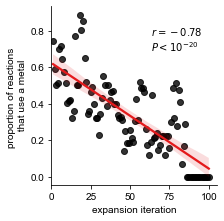

In [18]:
# compute the fraction of each iteration that uses a metal

# determine proportion of reactions per iteration that use CO2 as reductant
rns_tmp = pd.Series(ne_rxns).reset_index()
rns_tmp.columns = ['reaction','direction','iteration']
mtls = cids[cids['Coenzyme type/function'].isin(['Iron sulfur','Metal','Metal monovalent'])].ZID.tolist()

metal_using_reactions = metabolism.network[(metabolism.network.cid.isin(mtls))][['rn','direction']].drop_duplicates()
metal_using_reactions = metal_using_reactions.apply(tuple,axis=1).tolist()
z = rns_tmp[['reaction','direction']].apply(tuple, axis=1).apply(lambda x: x in metal_using_reactions)
rns_tmp['cofactor_usage'] = z
rns_tmp['total'] = 1
rz = rns_tmp.groupby('iteration').sum()
rz = rz['cofactor_usage'] / rz['total']

prop = pd.DataFrame(rz,columns = ['prop'])
sns.lmplot(x='iteration',y='prop',data=prop.reset_index(),height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlim([0,105])
plt.xlabel('expansion iteration')
plt.ylabel('proportion of reactions \n that use a metal')

r,pval = pearsonr(prop.reset_index()['iteration'].values,prop.reset_index()['prop'].values)
print(r)
print(pval)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.6, 0.75), xycoords='axes fraction')


### Fig 3D: average fold symmetry score vs. expansion number

Text(0.1, 0.1, '$r=-0.66$ \n$P<10^{-13}$')

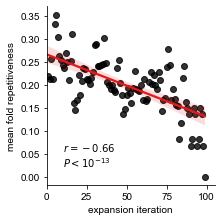

In [20]:
fold2rxns = pd.read_csv('../assets/fold2rxn.ec.30Aug2022.p20.csv',index_col=0)
fold2rxns.columns = ['rn','rule']
# only keepreaction to fold mappings from reactions mapping to a single KO group
singleKO = False
if singleKO:
    rn2ko_count = pd.read_csv("/Users/joshuagoldford/Documents/github/network-expansion-assets/assets/reaction.KOCount.csv")
    rn_list_fold_compare = rn2ko_count[rn2ko_count.ko == 1].rn.tolist()
    fold2rxns = fold2rxns[fold2rxns.rn.isin(rn_list_fold_compare)]

fold2rxns['rule'] = fold2rxns.rule.apply(lambda x: str(x))
fold_sym = pd.read_csv("../assets/xgroup_symmetry.txt",sep=',',header=None)
fold_sym = fold_sym[[0,1,2]]
fold_sym.columns = ['Fold','Symmmetry','Score']
fold_sym['Fold'] = fold_sym.Fold.apply(lambda x: str(x))

rn_folds = {'rn':[],'folds':[]}
for rn, dff in fold2rxns.groupby('rn'):
    folds = dff.rule.apply(lambda x: x.split('_')).tolist()
    F = []
    for f in folds:
        for ff in f:
            F.append(ff)
    F = set(F)
    rn_folds['rn'].append(rn)
    rn_folds['folds'].append(list(F))
    
rn_folds = pd.DataFrame(rn_folds)
rn_folds['average sym'] = rn_folds.folds.apply(lambda x: fold_sym[fold_sym.Fold.isin(x)].Score.mean())
rn_folds = rn_folds.dropna()
rn_folds['X-groups'] = rn_folds['folds'].apply(lambda x: ";".join(x))


scores = {'iteration': [] ,'mean_symmetry_score': []}

for iteration,dff in pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration']).groupby('iteration'):
    g = [x[0] for x in dff.index.tolist()]
    g = [x.split('_')[0] for x in g]
    scores['iteration'].append(iteration)
    s = rn_folds[rn_folds.rn.isin(g)]['average sym'].mean()
    scores['mean_symmetry_score'].append(s)
    
scores = pd.DataFrame(scores)
scores = scores.dropna()

sns.lmplot(x='iteration',y='mean_symmetry_score',data=scores,height=3, aspect=1,line_kws=lkws,scatter_kws=skws)
plt.xlim([0,105])
plt.ylabel('mean fold repetitiveness')
plt.xlabel('expansion iteration')


r,pval = pearsonr(scores['iteration'].values,scores['mean_symmetry_score'].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.1), xycoords='axes fraction')


### Fig 4C: Carbon fixation pathway

Text(0.5, -6.5, 'expansion iteration')

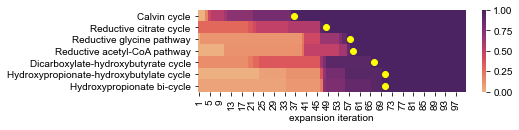

In [21]:
carbon_fixation = ['M00165','M00173','M00374','M00375','M00376','M00377','ReductiveGlycineModule']

module_set = pd.read_csv('../assets/carbonFixationModuleRules.v2.csv')
# this is a biotin-dependent step, whcih can be performed via PEP carboxylase which always occurs earlier
module_set = module_set[~(module_set["step"] == "C00022 -> C00036")]
module_names = {}
module_names['M00165'] = 'Calvin cycle'
module_names['M00173'] = 'Reductive citrate cycle'
module_names['M00374'] = 'Dicarboxylate-hydroxybutyrate cycle'
module_names['M00375'] = 'Hydroxypropionate-hydroxybutylate cycle'
module_names['M00376'] = 'Hydroxypropionate bi-cycle'
module_names['M00377'] = 'Reductive acetyl-CoA pathway'
module_names['ReductiveGlycineModule'] = 'Reductive glycine pathway'

iterations = rn_df.iteration.unique().tolist()
module_coverage = {'module':[],'iteration':[],'coverage':[]}


# make a reaction df with ONLY extant reactions
rn_df_extant = rn_df[~rn_df.rn.apply(lambda x: ("H2Red" in x) | ("_RSH" in x))]


for i in iterations:
    rsub = rn_df_extant[rn_df_extant.iteration < (i+1)]
    #rsub =rn_df[rn_df.iteration < (i+1)]
    rsub = rsub.rn_kegg.unique()
    for module,mdf in module_set.groupby('module'):
        z = mdf.reactions.apply(lambda x: any([y in rsub for y in x.split(',')]))
        coverage = z.sum() / len(z)
        module_coverage['module'].append(module)
        module_coverage['iteration'].append(i)
        module_coverage['coverage'].append(coverage)

module_coverage = pd.DataFrame(module_coverage)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

M00357 = pd.DataFrame(module_coverage_piv[['M00357.v1','M00357.v2']].max(axis=1))
M00357.columns = ['coverage']
M00357['module'] = 'M00357'

module_coverage = pd.concat([module_coverage,M00357.reset_index()[['module','iteration','coverage']]],axis=0)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

pathway_completion_iteration = pd.Series({x:y[y.coverage == 1].iteration.min() for x,y in module_coverage.groupby('module')})

height = 6
mods = carbon_fixation
q = pd.DataFrame(pathway_completion_iteration.loc[mods].sort_values(),columns = ['iteration']).reset_index().reset_index()
q.columns = ['rank','module','iteration']
mods = pathway_completion_iteration.loc[mods].sort_values().index.tolist()
n = len(mods)
plt.figure(figsize=(height,(n/2)/14*height))

z = module_coverage_piv[mods].T
z.index = [module_names[x] for x in z.index.tolist()]

ax = sns.heatmap(z,cmap='flare',yticklabels=True)
plt.yticks(rotation=0)

#y = q['rank'].values + (n/2 / 10)
y = ax.get_yticks()

x = q['iteration'].values
plt.scatter(x,y,color='yellow')
plt.xlabel('expansion iteration')
#plt.savefig('carbonfixation.{date}.svg'.format(date=date))
#plt.savefig("figs/fig4c.svg")

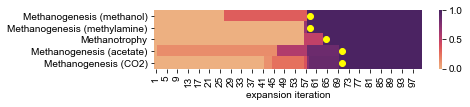

In [22]:

module_names = {}
module_names["M00174"] = "Methanotrophy"
module_names["M00356"]= "Methanogenesis (methanol)"
module_names["M00357"] = "Methanogenesis (acetate)"
module_names["M00563"]= "Methanogenesis (methylamine)"
module_names["M00567"]= "Methanogenesis (CO2)"
iterations = rn_df.iteration.unique().tolist()
module_coverage = {'module':[],'iteration':[],'coverage':[]}


# make a reaction df with ONLY extant reactions
rn_df_extant = rn_df[~rn_df.rn.apply(lambda x: ("H2Red" in x) | ("_RSH" in x))]


for i in iterations:
    rsub = rn_df_extant[rn_df_extant.iteration < (i+1)]
    #rsub =rn_df[rn_df.iteration < (i+1)]
    rsub = rsub.rn_kegg.unique()
    for module,mdf in module_set.groupby('module'):
        z = mdf.reactions.apply(lambda x: any([y in rsub for y in x.split(',')]))
        coverage = z.sum() / len(z)
        module_coverage['module'].append(module)
        module_coverage['iteration'].append(i)
        module_coverage['coverage'].append(coverage)

module_coverage = pd.DataFrame(module_coverage)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

#module_coverage = pd.concat([module_coverage,M00357.reset_index()[['module','iteration','coverage']]],axis=0)
#module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

pathway_completion_iteration = pd.Series({x:y[y.coverage == 1].iteration.min() for x,y in module_coverage.groupby('module')})

height = 6
mods = list(module_names)
q = pd.DataFrame(pathway_completion_iteration.loc[mods].sort_values(),columns = ['iteration']).reset_index().reset_index()
q.columns = ['rank','module','iteration']
mods = pathway_completion_iteration.loc[mods].sort_values().index.tolist()
n = len(mods)
plt.figure(figsize=(height,(n/2)/14*height))

z = module_coverage_piv[mods].T
z.index = [module_names[x] for x in z.index.tolist()]

ax = sns.heatmap(z,cmap='flare',yticklabels=True)
plt.yticks(rotation=0)

#y = q['rank'].values + (n/2 / 10)
y = ax.get_yticks()

x = q['iteration'].values
plt.scatter(x,y,color='yellow')
plt.xlabel('expansion iteration')
#plt.savefig('carbonfixation.{date}.svg'.format(date=date))


### Fig 4A: analysis of linear pathways

/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


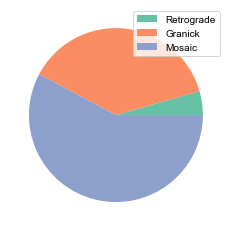

In [23]:
with open("../assets/parsedLinearModules.pkl","rb") as filehandler:
    parsed_linear_modules = pickle.load(filehandler)
    
rn_df['rlabel'] = rn_df['rn_kegg'] + '_' + rn_df['direction']

iteration_step = []
for idx,row in parsed_linear_modules.iterrows():
    if rn_df.rlabel.isin(row.rxn_labels).sum() == len(row.rxn_labels):
        step_max = rn_df[rn_df.rlabel.isin(row.rxn_labels)].iteration.max()
    else:
        step_max = np.nan
    iteration_step.append(step_max)
    
parsed_linear_modules['iteration'] = iteration_step


module_correlations = {'module':[],'rule_id':[],'r':[],'pval':[],'ivar':[]}
for (module,rule),dff in parsed_linear_modules.groupby(['module','rule_id']):
    if ~dff.iteration.isna().any():
        if len(dff)>1:
            r,p = spearmanr(dff.step,dff.iteration)
            module_correlations['module'].append(module)
            module_correlations['rule_id'].append(rule)
            module_correlations['r'].append(r)
            module_correlations['pval'].append(p)
            module_correlations['ivar'].append(dff.iteration.var())
module_correlations = pd.DataFrame(module_correlations)


retrograde = len(module_correlations[module_correlations.r == -1])
granick = len(module_correlations[module_correlations.r == 1])
mosiac = len(module_correlations) - retrograde - granick

plt.figure(figsize=(4,4))
cmap2 = sns.color_palette("Set2")
plt.pie([retrograde,granick,mosiac],colors=cmap2)
plt.legend(['Retrograde','Granick','Mosaic'])


### Fig 4B: Compute emergence time of KEGG modules

Text(0.5, 6.800000000000001, 'iteration when pathway is feasible')

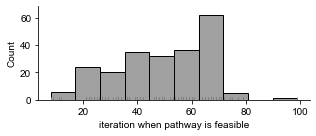

In [24]:
with open("../assets/parsedModules.pkl","rb") as filehandler:
    parsed_modules = pickle.load(filehandler)

moduleEmergence = {'module':[],'rule_id':[],'iteration_emergence':[]}

for (module,rule),mdf in parsed_modules.groupby(['module','rule_id']):
    mdf['in_expansion'] = mdf.rxn_labels.apply(lambda x: len(rn_df[rn_df.rlabel.isin(x)])>0)
    if mdf.in_expansion.all():
        mdf['iteration'] = mdf.rxn_labels.apply(lambda x: rn_df[rn_df.rlabel.isin(x)].iteration.min())
        emergence_time = mdf.groupby('step').min().iteration.max()
        moduleEmergence['iteration_emergence'].append(emergence_time)
        moduleEmergence['module'].append(module)
        moduleEmergence['rule_id'].append(rule)

# substitute the manually constructed pathways into automatically parsed KEGG modules
memerg = pd.DataFrame(module_coverage.groupby('module').apply(lambda x:  x[x.coverage == 1].iteration.min()))
memerg.columns = ['iteration_emergence']
memerg = memerg[~memerg.index.isin(['M00357.v1','M00357.v2'])]

moduleEmergence = pd.DataFrame(moduleEmergence)
moduleEmergenceMin = moduleEmergence.dropna().groupby('module').min()
moduleEmergenceMin = pd.concat([moduleEmergenceMin[~moduleEmergenceMin.index.isin(memerg.index.tolist())][['iteration_emergence']],memerg],axis=0)

sns.displot(x='iteration_emergence',data=moduleEmergenceMin,height=2,aspect=2.25,color='gray',rug=True)
plt.xlabel('iteration when pathway is feasible')